# Imports

In [1]:
!pip install optuna
!pip install dtreeviz
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 7.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 14.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import graphviz
import dtreeviz
import optuna
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss
from sklearn import tree
from sklearn.metrics import fbeta_score, make_scorer
import shap

# Reading the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
bank = pd.read_csv('drive/MyDrive/COMP3820/project/bank/clean_bank.csv')
predictors = list(bank.columns[:-1])
bank = bank[predictors]

index_train_v, index_test = train_test_split(bank.index, train_size=0.7, random_state=7)


train_v = bank.loc[index_train_v, :].copy()
test = bank.loc[index_test, :].copy()

index_train, index_valid = train_test_split(train_v.index, train_size=0.8, random_state=7)

train = train_v.loc[index_train, :].copy()
valid = train_v.loc[index_valid, :].copy()


X_train = train.loc[:, train.columns!='y']
X_valid = valid.loc[:, test.columns!='y']
X_test = test.loc[:, test.columns!='y']

# predictors = list(X_train.columns)

y_train = train['y']
y_valid = valid['y']
y_test = test['y']

In [5]:
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y
17211,58,services,married,unknown,unknown,yes,no,cellular,aug,tue,999,0,nonexistent,1.4,93.444,-36.1,4.968,5228.1,0
158,56,admin.,divorced,unknown,unknown,no,no,telephone,may,mon,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
30440,43,blue-collar,married,basic4y,no,no,yes,cellular,may,thu,11,1,success,-1.8,92.893,-46.2,1.266,5099.1,1
13445,26,technician,divorced,professional,no,no,yes,cellular,jul,tue,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,1
8538,30,admin.,divorced,university,unknown,yes,no,telephone,jun,fri,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,0


In [6]:
bank['housing'].unique()

array(['no', 'yes', 'unknown'], dtype=object)

In [7]:
features = ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']

# Encoding the nominal data

In [8]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.2 MB/s eta 0:00:00


In [9]:
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.glmm import GLMMEncoder
from category_encoders.cat_boost import CatBoostEncoder

In [10]:
# We dont encode the discrete values because decision trees take a range anyways so we dont have to.

nominal = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

for x in nominal:
    # Target encoder
    encoder = TargetEncoder().fit(train[x], y_train) # we must use the training set for this
    train[x+'TE'] = encoder.transform(train[x])
    valid[x+'TE'] = encoder.transform(valid[x])
    test[x+'TE'] = encoder.transform(test[x])


    # Leave one out encoder
    encoder = LeaveOneOutEncoder().fit(train[x], y_train) 
    train[x+'LeaveOneOut'] = encoder.transform(train[x])
    valid[x+'LeaveOneOut'] = encoder.transform(valid[x])
    test[x+'LeaveOneOut'] = encoder.transform(test[x])

    # GLMM encoder
    encoder =  GLMMEncoder().fit(train[x], y_train)
    train[x+'GLMM'] = encoder.transform(train[x])
    valid[x+'GLMM'] = encoder.transform(valid[x])
    test[x+'GLMM'] = encoder.transform(test[x])

    # CatBoostEncoder
    encoder = CatBoostEncoder().fit(train[x], y_train) 
    train[x+'CatBoost'] = encoder.transform(train[x])
    valid[x+'CatBoost'] = encoder.transform(valid[x])
    test[x+'CatBoost'] = encoder.transform(test[x])
    
    # One-hot encoder
    dummies = pd.get_dummies(bank[x],  prefix = x)
    train = train.join(dummies.loc[index_train, :])
    valid = valid.join(dummies.loc[index_valid, :])
    test = test.join(dummies.loc[index_test, :])
    globals()['%s_OneHot' % x] = list(dummies.columns)

In [11]:
keys = {
        'unknown' : 0,
        'basic4y' : 1, 
        'basic6y' : 2,
        'basic9y' : 3, 
        'highSchool' : 4, 
        'professional' : 5, 
        'university' : 6
}



variable = 'education'

train['educationOrdinal'] = train[variable].replace(keys).astype(int)
valid['educationOrdinal'] = valid[variable].replace(keys).astype(int)
test['educationOrdinal'] = test[variable].replace(keys).astype(int)

In [12]:
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,day_of_week_tue,day_of_week_wed,poutcomeTE,poutcomeLeaveOneOut,poutcomeGLMM,poutcomeCatBoost,poutcome_failure,poutcome_nonexistent,poutcome_success,educationOrdinal
17211,58,services,married,unknown,unknown,yes,no,cellular,aug,tue,...,1,0,0.096665,0.096665,-1.231051,0.096666,0,1,0,0
158,56,admin.,divorced,unknown,unknown,no,no,telephone,may,mon,...,0,0,0.096665,0.096665,-1.231051,0.096666,0,1,0,0
30440,43,blue-collar,married,basic4y,no,no,yes,cellular,may,thu,...,0,0,0.652956,0.652956,1.631809,0.652276,0,0,1,1
13445,26,technician,divorced,professional,no,no,yes,cellular,jul,tue,...,1,0,0.096665,0.096665,-1.231051,0.096666,0,1,0,5
8538,30,admin.,divorced,university,unknown,yes,no,telephone,jun,fri,...,0,0,0.096665,0.096665,-1.231051,0.096666,0,1,0,6


In [13]:
nominal

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

# Testing the different encodings

In [14]:
from sklearn.metrics import f1_score

def test_encodings(algo, variables):

  results_df_dic = {}
  for x in nominal:

      rows = ['One-Hot encoding', 'Target encoder', 'Leave-one-out encoder', 
              'GLMM encoder', 'CatBoost encoder', 'ordinal encoder']

      columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision', 'F1-score']

      results = pd.DataFrame(0.0, columns=columns, index=rows)
    

      y_prob = np.zeros((len(y_valid), len(rows)))
      for i in range(len(rows)):
        if i == 5 and x != 'education':
          continue
        feature = []
        if i==0:
            feature = variables + globals()['%s_OneHot' % x]
        elif i==1: 
            feature = variables + [x+'TE'] 
        elif i==2:
            feature = variables + [x+'LeaveOneOut']
        elif i==3: 
            feature = variables + [x+'GLMM']
        elif i==4: 
            feature = variables + [x+'CatBoost']  
        if x == 'education':
          if i==5:
            feature = variables + ['educationOrdinal']
        
        X_train = train[feature]
        X_valid = valid[feature]
        model = algo
        model.fit(X_train, y_train)

        # validation set predictions
        
        y_prob[:, i] = model.predict_proba(X_valid)[:, 1]

        lfp = 1
        lfn = 19
        tau = lfp/(lfp+lfn)

        y_prob[:, i][y_prob[:,i] < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
        y_prob[:, i][y_prob[:,i] > 1- 1e-5] =  1- 1e-5

        y_pred = (y_prob[:,i] > tau).astype(int)
        # y_pred = model.predict(X_valid)
              
        tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

        results.iloc[i,0] =  log_loss(y_valid, y_prob[:,i])   # Cross entropy
        results.iloc[i,1] =   1 - accuracy_score(y_valid, y_pred)   # Error rate
        results.iloc[i,2] =  roc_auc_score(y_valid, y_prob[:,i])   # AUC
        results.iloc[i,3] =  tp/(tp+fn)   # Sensitivity 
        results.iloc[i,4] =  tn/(tn+fp)   # Specificity	
        results.iloc[i,5] =  precision_score(y_valid, y_pred)   # Precision
        results.iloc[i, 6] = f1_score(y_valid, y_pred)

        


      if x not in results_df_dic:
          results_df_dic[x] = results
  return results_df_dic

# Best encoding for decision tree

In [15]:

results_df_dic = test_encodings(tree.DecisionTreeClassifier(random_state=42), features)

In [16]:
for key in results_df_dic:
    print(key)
    display(results_df_dic[key].sort_values(by=['AUC'], ascending = [0]).round(5))

job


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,1.61263,0.25183,0.59028,0.34264,0.80567,0.20000,0.25257
GLMM encoder,1.65673,0.25741,0.58201,0.33333,0.80062,0.19162,0.24335
Target encoder,1.66209,0.25895,0.58110,0.33333,0.79886,0.19027,0.24225
Leave-one-out encoder,1.66209,0.25895,0.58110,0.33333,0.79886,0.19027,0.24225
CatBoost encoder,1.66209,0.25895,0.58110,0.33333,0.79886,0.19027,0.24225
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


marital


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,1.41447,0.32865,0.59048,0.4124,0.70807,0.16688,0.23761
Target encoder,1.42422,0.33038,0.58759,0.4093,0.70653,0.16510,0.23529
Leave-one-out encoder,1.42422,0.33038,0.58759,0.4093,0.70653,0.16510,0.23529
CatBoost encoder,1.42422,0.33038,0.58759,0.4093,0.70653,0.16510,0.23529
GLMM encoder,1.43526,0.33211,0.58168,0.4000,0.70587,0.16165,0.23025
ordinal encoder,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000


education


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,1.57064,0.25760,0.59331,0.35659,0.7971,0.19948,0.25584
Target encoder,1.56987,0.25529,0.59203,0.35194,0.8004,0.20000,0.25506
Leave-one-out encoder,1.56987,0.25529,0.59203,0.35194,0.8004,0.20000,0.25506
GLMM encoder,1.56987,0.25529,0.59203,0.35194,0.8004,0.20000,0.25506
CatBoost encoder,1.56987,0.25529,0.59203,0.35194,0.8004,0.20000,0.25506
ordinal encoder,1.63214,0.25895,0.57893,0.33023,0.7993,0.18917,0.24054


default


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Target encoder,1.31955,0.35580,0.58473,0.43876,0.67333,0.15998,0.23447
Leave-one-out encoder,1.31955,0.35580,0.58473,0.43876,0.67333,0.15998,0.23447
GLMM encoder,1.31955,0.35580,0.58473,0.43876,0.67333,0.15998,0.23447
CatBoost encoder,1.31955,0.35580,0.58473,0.43876,0.67333,0.15998,0.23447
One-Hot encoding,1.34837,0.35772,0.58060,0.43411,0.67180,0.15792,0.23160
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


housing


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Target encoder,1.46580,0.33077,0.57472,0.3876,0.70917,0.15893,0.22543
Leave-one-out encoder,1.46580,0.33077,0.57472,0.3876,0.70917,0.15893,0.22543
GLMM encoder,1.46580,0.33077,0.57472,0.3876,0.70917,0.15893,0.22543
CatBoost encoder,1.46580,0.33077,0.57472,0.3876,0.70917,0.15893,0.22543
One-Hot encoding,1.49151,0.33269,0.57044,0.3814,0.70785,0.15619,0.22162
ordinal encoder,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000


loan


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,1.36509,0.35830,0.58727,0.44806,0.66916,0.16109,0.23698
GLMM encoder,1.38000,0.35849,0.58510,0.44496,0.66938,0.16025,0.23563
Target encoder,1.37850,0.35849,0.58075,0.43566,0.67070,0.15795,0.23185
Leave-one-out encoder,1.37850,0.35849,0.58075,0.43566,0.67070,0.15795,0.23185
CatBoost encoder,1.37850,0.35849,0.58075,0.43566,0.67070,0.15795,0.23185
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


contact


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,1.24620,0.39064,0.58166,0.47132,0.62893,0.15261,0.23057
Target encoder,1.24888,0.39161,0.57541,0.46202,0.62915,0.15013,0.22662
Leave-one-out encoder,1.24888,0.39161,0.57541,0.46202,0.62915,0.15013,0.22662
GLMM encoder,1.24888,0.39161,0.57541,0.46202,0.62915,0.15013,0.22662
CatBoost encoder,1.24888,0.39161,0.57541,0.46202,0.62915,0.15013,0.22662
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


month


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,1.26392,0.40354,0.57805,0.47132,0.61420,0.14764,0.22485
Target encoder,1.28345,0.40508,0.56833,0.45736,0.61442,0.14397,0.21901
Leave-one-out encoder,1.28345,0.40508,0.56833,0.45736,0.61442,0.14397,0.21901
GLMM encoder,1.28345,0.40508,0.56833,0.45736,0.61442,0.14397,0.21901
CatBoost encoder,1.28345,0.40508,0.56833,0.45736,0.61442,0.14397,0.21901
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


day_of_week


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,1.32016,0.34598,0.59737,0.44186,0.68411,0.16551,0.24081
Target encoder,1.32816,0.34694,0.59459,0.43876,0.68345,0.16425,0.23902
Leave-one-out encoder,1.32816,0.34694,0.59459,0.43876,0.68345,0.16425,0.23902
GLMM encoder,1.32816,0.34694,0.59459,0.43876,0.68345,0.16425,0.23902
CatBoost encoder,1.32816,0.34694,0.59459,0.43876,0.68345,0.16425,0.23902
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


poutcome


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Target encoder,1.24794,0.40219,0.57910,0.47132,0.61574,0.14815,0.22544
Leave-one-out encoder,1.24794,0.40219,0.57910,0.47132,0.61574,0.14815,0.22544
GLMM encoder,1.24794,0.40219,0.57910,0.47132,0.61574,0.14815,0.22544
CatBoost encoder,1.24794,0.40219,0.57910,0.47132,0.61574,0.14815,0.22544
One-Hot encoding,1.24314,0.40142,0.57677,0.46667,0.61728,0.14740,0.22404
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## Summary of encodings for decision tree

- **job**: One-Hot encoding	
- **martial**: One-Hot encoding	
- **education**: One-Hot encoding
- **default**: GLMM encoder
- **housing**: Leave-one-out encoder
- **loan**: One-Hot encoding
- **contact**: One-Hot encoding
- **month**: One-Hot encoding
- **day_of_week**: One-Hot encoding
- **poutcome**: One-Hot encoding

# Best encoding for Random forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
rf =  RandomForestClassifier(n_estimators=100,  criterion='entropy',  max_features = 3, min_samples_leaf= 5, random_state=42)
results_df_dic = test_encodings(rf, features)

In [19]:
for key in results_df_dic:
    print(key)
    display(results_df_dic[key].sort_values(by=['AUC'], ascending = [0]).round(5))

job


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.31528,0.48190,0.76550,0.80775,0.47703,0.17966,0.29394
GLMM encoder,0.32085,0.45745,0.76487,0.80000,0.50605,0.18675,0.30282
Target encoder,0.32287,0.45437,0.76202,0.79535,0.51022,0.18716,0.30301
Leave-one-out encoder,0.32287,0.45437,0.76202,0.79535,0.51022,0.18716,0.30301
CatBoost encoder,0.32287,0.45437,0.76202,0.79535,0.51022,0.18716,0.30301
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


marital


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.31304,0.47362,0.76901,0.8124,0.48582,0.18302,0.29875
Target encoder,0.32170,0.46072,0.76766,0.8062,0.50143,0.18651,0.30294
Leave-one-out encoder,0.32170,0.46072,0.76766,0.8062,0.50143,0.18651,0.30294
CatBoost encoder,0.32170,0.46072,0.76766,0.8062,0.50143,0.18651,0.30294
GLMM encoder,0.32578,0.45861,0.76603,0.8031,0.50429,0.18680,0.30310
ordinal encoder,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000


education


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Target encoder,0.32303,0.46169,0.76255,0.79845,0.50143,0.18505,0.30047
Leave-one-out encoder,0.32303,0.46169,0.76255,0.79845,0.50143,0.18505,0.30047
GLMM encoder,0.32303,0.46169,0.76255,0.79845,0.50143,0.18505,0.30047
CatBoost encoder,0.32303,0.46169,0.76255,0.79845,0.50143,0.18505,0.30047
One-Hot encoding,0.32553,0.46284,0.76220,0.78915,0.50143,0.18329,0.29749
ordinal encoder,0.32579,0.45726,0.76066,0.78605,0.50824,0.18477,0.29920


default


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.32661,0.47112,0.75941,0.79070,0.49176,0.18072,0.29420
Target encoder,0.33557,0.47074,0.75750,0.78915,0.49242,0.18062,0.29396
GLMM encoder,0.33557,0.47074,0.75750,0.78915,0.49242,0.18062,0.29396
Leave-one-out encoder,0.33618,0.46977,0.75745,0.78915,0.49352,0.18095,0.29439
CatBoost encoder,0.33618,0.46977,0.75745,0.78915,0.49352,0.18095,0.29439
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


housing


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Target encoder,0.32719,0.46284,0.76225,0.7969,0.50033,0.18443,0.29953
Leave-one-out encoder,0.32719,0.46284,0.76225,0.7969,0.50033,0.18443,0.29953
GLMM encoder,0.32719,0.46284,0.76225,0.7969,0.50033,0.18443,0.29953
CatBoost encoder,0.32719,0.46284,0.76225,0.7969,0.50033,0.18443,0.29953
One-Hot encoding,0.32834,0.45995,0.76221,0.8031,0.50275,0.18633,0.30248
ordinal encoder,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000


loan


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.32738,0.47478,0.76020,0.79535,0.48692,0.18019,0.29381
GLMM encoder,0.32911,0.47382,0.75915,0.79535,0.48802,0.18051,0.29424
Target encoder,0.33521,0.46785,0.75867,0.79380,0.49505,0.18227,0.29647
Leave-one-out encoder,0.33521,0.46785,0.75867,0.79380,0.49505,0.18227,0.29647
CatBoost encoder,0.33521,0.46785,0.75867,0.79380,0.49505,0.18227,0.29647
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


contact


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.32974,0.48152,0.76447,0.8124,0.47681,0.18044,0.29529
Target encoder,0.33185,0.48363,0.76339,0.8093,0.47483,0.17932,0.29359
Leave-one-out encoder,0.33185,0.48363,0.76339,0.8093,0.47483,0.17932,0.29359
GLMM encoder,0.33185,0.48363,0.76339,0.8093,0.47483,0.17932,0.29359
CatBoost encoder,0.33185,0.48363,0.76339,0.8093,0.47483,0.17932,0.29359
ordinal encoder,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000


month


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.33648,0.49673,0.75841,0.80465,0.46054,0.17457,0.28690
Target encoder,0.34123,0.49211,0.75763,0.80620,0.46560,0.17621,0.28921
Leave-one-out encoder,0.34123,0.49211,0.75763,0.80620,0.46560,0.17621,0.28921
GLMM encoder,0.34123,0.49211,0.75763,0.80620,0.46560,0.17621,0.28921
CatBoost encoder,0.34123,0.49211,0.75763,0.80620,0.46560,0.17621,0.28921
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


day_of_week


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Target encoder,0.32762,0.44686,0.76919,0.80155,0.51792,0.19077,0.30820
Leave-one-out encoder,0.32762,0.44686,0.76919,0.80155,0.51792,0.19077,0.30820
GLMM encoder,0.32762,0.44686,0.76919,0.80155,0.51792,0.19077,0.30820
CatBoost encoder,0.32762,0.44686,0.76919,0.80155,0.51792,0.19077,0.30820
One-Hot encoding,0.32458,0.45418,0.76903,0.80000,0.50978,0.18791,0.30434
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


poutcome


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.33626,0.49422,0.75917,0.81240,0.46230,0.17643,0.28990
Target encoder,0.33818,0.49442,0.75742,0.80465,0.46318,0.17528,0.28785
Leave-one-out encoder,0.33818,0.49442,0.75742,0.80465,0.46318,0.17528,0.28785
GLMM encoder,0.33818,0.49442,0.75742,0.80465,0.46318,0.17528,0.28785
CatBoost encoder,0.33818,0.49442,0.75742,0.80465,0.46318,0.17528,0.28785
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## Summary of encodings for random forest

- **job**: One-Hot encoding
- **martial**: One-Hot encoding
- **education**: Leave-one-out encoder	
- **default**: One-Hot encoding	
- **housing**: Leave-one-out encoder	
- **loan**: One-Hot encoding
- **contact**: One-Hot encoding
- **month**: One-Hot encoding
- **day_of_week**: Leave-one-out encoder	
- **poutcome**: One-Hot encoding

# Best encoding for Bagging

In [20]:
from sklearn.ensemble import BaggingClassifier

In [21]:
bag = BaggingClassifier(tree.DecisionTreeClassifier(criterion='entropy'), n_estimators=1000, random_state=42)
results_df_dic = test_encodings(rf, features)
for key in results_df_dic:
    print(key)
    display(results_df_dic[key].sort_values(by=['AUC'], ascending = [0]).round(5))

job


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.31528,0.48190,0.76550,0.80775,0.47703,0.17966,0.29394
GLMM encoder,0.32085,0.45745,0.76487,0.80000,0.50605,0.18675,0.30282
Target encoder,0.32287,0.45437,0.76202,0.79535,0.51022,0.18716,0.30301
Leave-one-out encoder,0.32287,0.45437,0.76202,0.79535,0.51022,0.18716,0.30301
CatBoost encoder,0.32287,0.45437,0.76202,0.79535,0.51022,0.18716,0.30301
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


marital


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.31304,0.47362,0.76901,0.8124,0.48582,0.18302,0.29875
Target encoder,0.32170,0.46072,0.76766,0.8062,0.50143,0.18651,0.30294
Leave-one-out encoder,0.32170,0.46072,0.76766,0.8062,0.50143,0.18651,0.30294
CatBoost encoder,0.32170,0.46072,0.76766,0.8062,0.50143,0.18651,0.30294
GLMM encoder,0.32578,0.45861,0.76603,0.8031,0.50429,0.18680,0.30310
ordinal encoder,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000


education


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Target encoder,0.32303,0.46169,0.76255,0.79845,0.50143,0.18505,0.30047
Leave-one-out encoder,0.32303,0.46169,0.76255,0.79845,0.50143,0.18505,0.30047
GLMM encoder,0.32303,0.46169,0.76255,0.79845,0.50143,0.18505,0.30047
CatBoost encoder,0.32303,0.46169,0.76255,0.79845,0.50143,0.18505,0.30047
One-Hot encoding,0.32553,0.46284,0.76220,0.78915,0.50143,0.18329,0.29749
ordinal encoder,0.32579,0.45726,0.76066,0.78605,0.50824,0.18477,0.29920


default


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.32661,0.47112,0.75941,0.79070,0.49176,0.18072,0.29420
Target encoder,0.33557,0.47074,0.75750,0.78915,0.49242,0.18062,0.29396
GLMM encoder,0.33557,0.47074,0.75750,0.78915,0.49242,0.18062,0.29396
Leave-one-out encoder,0.33618,0.46977,0.75745,0.78915,0.49352,0.18095,0.29439
CatBoost encoder,0.33618,0.46977,0.75745,0.78915,0.49352,0.18095,0.29439
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


housing


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Target encoder,0.32719,0.46284,0.76225,0.7969,0.50033,0.18443,0.29953
Leave-one-out encoder,0.32719,0.46284,0.76225,0.7969,0.50033,0.18443,0.29953
GLMM encoder,0.32719,0.46284,0.76225,0.7969,0.50033,0.18443,0.29953
CatBoost encoder,0.32719,0.46284,0.76225,0.7969,0.50033,0.18443,0.29953
One-Hot encoding,0.32834,0.45995,0.76221,0.8031,0.50275,0.18633,0.30248
ordinal encoder,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000


loan


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.32738,0.47478,0.76020,0.79535,0.48692,0.18019,0.29381
GLMM encoder,0.32911,0.47382,0.75915,0.79535,0.48802,0.18051,0.29424
Target encoder,0.33521,0.46785,0.75867,0.79380,0.49505,0.18227,0.29647
Leave-one-out encoder,0.33521,0.46785,0.75867,0.79380,0.49505,0.18227,0.29647
CatBoost encoder,0.33521,0.46785,0.75867,0.79380,0.49505,0.18227,0.29647
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


contact


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.32974,0.48152,0.76447,0.8124,0.47681,0.18044,0.29529
Target encoder,0.33185,0.48363,0.76339,0.8093,0.47483,0.17932,0.29359
Leave-one-out encoder,0.33185,0.48363,0.76339,0.8093,0.47483,0.17932,0.29359
GLMM encoder,0.33185,0.48363,0.76339,0.8093,0.47483,0.17932,0.29359
CatBoost encoder,0.33185,0.48363,0.76339,0.8093,0.47483,0.17932,0.29359
ordinal encoder,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000


month


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.33648,0.49673,0.75841,0.80465,0.46054,0.17457,0.28690
Target encoder,0.34123,0.49211,0.75763,0.80620,0.46560,0.17621,0.28921
Leave-one-out encoder,0.34123,0.49211,0.75763,0.80620,0.46560,0.17621,0.28921
GLMM encoder,0.34123,0.49211,0.75763,0.80620,0.46560,0.17621,0.28921
CatBoost encoder,0.34123,0.49211,0.75763,0.80620,0.46560,0.17621,0.28921
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


day_of_week


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Target encoder,0.32762,0.44686,0.76919,0.80155,0.51792,0.19077,0.30820
Leave-one-out encoder,0.32762,0.44686,0.76919,0.80155,0.51792,0.19077,0.30820
GLMM encoder,0.32762,0.44686,0.76919,0.80155,0.51792,0.19077,0.30820
CatBoost encoder,0.32762,0.44686,0.76919,0.80155,0.51792,0.19077,0.30820
One-Hot encoding,0.32458,0.45418,0.76903,0.80000,0.50978,0.18791,0.30434
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


poutcome


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
One-Hot encoding,0.33626,0.49422,0.75917,0.81240,0.46230,0.17643,0.28990
Target encoder,0.33818,0.49442,0.75742,0.80465,0.46318,0.17528,0.28785
Leave-one-out encoder,0.33818,0.49442,0.75742,0.80465,0.46318,0.17528,0.28785
GLMM encoder,0.33818,0.49442,0.75742,0.80465,0.46318,0.17528,0.28785
CatBoost encoder,0.33818,0.49442,0.75742,0.80465,0.46318,0.17528,0.28785
ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## Summary of encodings for bagging

- **job**: One-Hot/GLMM encoder
- **martial**: One-Hot/Target encoder
- **education**: Target encoder
- **default**: One-Hot encoder
- **housing**: GLMM
- **loan**: One-Hot/GLMM
- **contact**: One-Hot/target encoding
- **month**: One-Hot/Target
- **day_of_week**: GLMM
- **poutcome**: One-Hot

# Hyperparameter training for Decision tree

## Benchmark decision tree without any tuning with best encodings

## Summary of encodings for decision tree

- **job**: One-Hot encoding	
- **martial**: Leave-one-out encoder
- **education**: One-Hot encoding
- **default**: One-Hot encoding
- **housing**: Leave-one-out encoder
- **loan**: Leave-one-out encoder
- **contact**: Leave-one-out encoder
- **month**: Leave-one-out encoder
- **day_of_week**: Leave-one-out encoder
- **poutcome**: One-Hot encoding

In [22]:
best_encodings_for_dt = {'OneHot': ['job', 'education', 'default', 'poutcome'], 'LeaveOneOut': ['marital', 'housing', 'loan', 'contact', 'month', 'day_of_week']}

def get_feature_encodings(encoding_dic):
  best_features = []
  for i in encoding_dic:
    for j in encoding_dic[i]:
      if i == 'OneHot':
        best_features = best_features + globals()['%s_OneHot' % j]
      else:
        best_features = best_features + [j + i]
  return best_features

best_features_for_dt = get_feature_encodings(best_encodings_for_dt)

In [23]:
features = ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
feature_for_dt = best_features_for_dt + features

def get_model_performance(algo, feature_list, algo_name):

  X_train = train[feature_list]
  X_test = test[feature_list]
  model = algo
  model.fit(X_train, y_train)

  # validation set predictions
  y_prob = np.zeros(len(y_test))
  y_prob = model.predict_proba(X_test)[:, 1]

  lfp = 1
  lfn = 19
  tau = lfp/(lfp+lfn)

  y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
  y_prob[y_prob > 1- 1e-5] =  1- 1e-5

  y_pred = (y_prob > tau).astype(int)
  # y_pred = model.predict(X_valid)
        
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

  columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision', 'F1-score']

  results = pd.DataFrame(0.0, columns=columns, index=[algo_name])

  results.iloc[:,0] =  log_loss(y_test, y_prob)   # Cross entropy
  results.iloc[:,1] =   1 - accuracy_score(y_test, y_pred)   # Error rate
  results.iloc[:,2] =  roc_auc_score(y_test, y_prob)   # AUC
  results.iloc[:,3] =  tp/(tp+fn)   # Sensitivity 
  results.iloc[:,4] =  tn/(tn+fp)   # Specificity	
  results.iloc[:,5] =  precision_score(y_test, y_pred)   # Precision
  results.iloc[:,6] =  f1_score(y_test, y_pred)
  return results, model

decision_tree = tree.DecisionTreeClassifier(random_state=42)
results, fitted_model = get_model_performance(decision_tree, feature_for_dt, "Decision Tree")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Decision Tree,2.11088,0.18949,0.61099,0.34667,0.87454,0.27611,0.30739


In [ ]:
feature_for_dt

['job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'education_basic4y',
 'education_basic6y',
 'education_basic9y',
 'education_highSchool',
 'education_professional',
 'education_university',
 'education_unknown',
 'default_no',
 'default_unknown',
 'default_yes',
 'poutcome_failure',
 'poutcome_nonexistent',
 'poutcome_success',
 'maritalLeaveOneOut',
 'housingLeaveOneOut',
 'loanLeaveOneOut',
 'contactLeaveOneOut',
 'monthLeaveOneOut',
 'day_of_weekLeaveOneOut',
 'age',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor_3m',
 'nr_employed']

## Decision Tree tuning using optuna

In [ ]:
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 40)
    max_features = trial.suggest_int('max_features', 1, 39)
    
    
    model = tree.DecisionTreeClassifier(random_state=42, criterion = criterion, max_features = max_features, min_samples_leaf= min_samples_leaf)
  
    scores = cross_val_score(model, train[feature_for_dt], y_train, cv = 5, scoring = 'f1')
    loss = np.mean(scores)
    
    return loss

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials = 1000, timeout = 120) 

[I 2023-05-23 11:45:59,867] A new study created in memory with name: no-name-10ef3b62-0c9d-4c1f-9c1d-86760a045e75
[I 2023-05-23 11:46:00,164] Trial 0 finished with value: 0.3780367409264455 and parameters: {'criterion': 'gini', 'min_samples_leaf': 30, 'max_features': 24}. Best is trial 0 with value: 0.3780367409264455.
[I 2023-05-23 11:46:00,688] Trial 1 finished with value: 0.33997416362087274 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 3, 'max_features': 34}. Best is trial 0 with value: 0.3780367409264455.
[I 2023-05-23 11:46:01,286] Trial 2 finished with value: 0.3011805530982152 and parameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 38}. Best is trial 0 with value: 0.3780367409264455.
[I 2023-05-23 11:46:01,489] Trial 3 finished with value: 0.3440412176123835 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 8, 'max_features': 8}. Best is trial 0 with value: 0.3780367409264455.
[I 2023-05-23 11:46:01,711] Trial 4 finished with value

KeyboardInterrupt: ignored

In [ ]:
params = study.best_params
params = {'criterion': 'entropy', 'min_samples_leaf': 40, 'max_features': 28}

In [ ]:
params

{'criterion': 'entropy', 'min_samples_leaf': 40, 'max_features': 28}

In [ ]:
decision_tree = tree.DecisionTreeClassifier(random_state=42, **params)
results, fitted_model = get_model_performance(decision_tree, feature_for_dt, "Decision Tree")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Decision Tree,0.35589,0.47727,0.77939,0.83333,0.47986,0.1811,0.29754


# Shap value

In [ ]:
shap.initjs()

explainer = shap.Explainer(fitted_model)
shap_values = explainer.shap_values(test[feature_for_dt])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


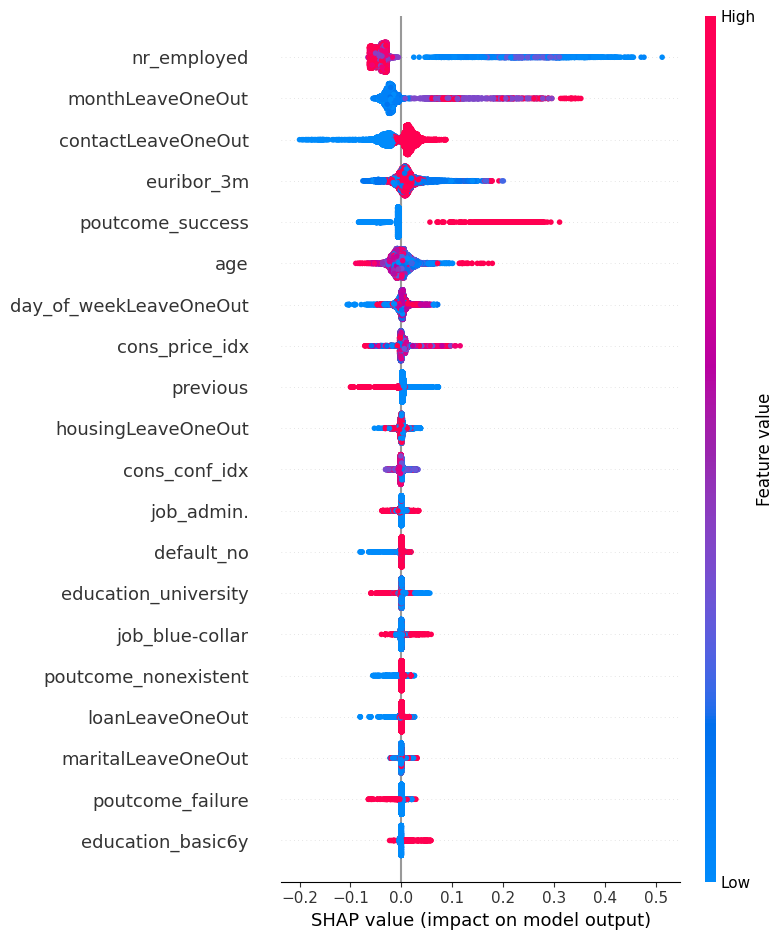

In [ ]:
shap.summary_plot(shap_values[1], test[feature_for_dt])

## Confusion matrix for this tree

In [ ]:
def plot_cm(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total subscribed Transactions: ', np.sum(cm[1]))

(True Negatives):  2169
(False Positives):  2380
(False Negatives):  118
(True Positives):  527
Total subscribed Transactions:  645


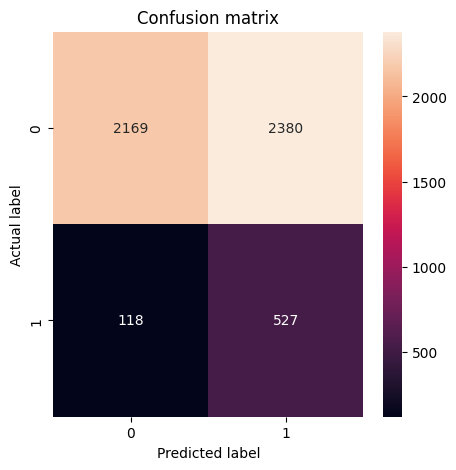

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = decision_tree.predict_proba(valid[feature_for_dt])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)
# y_pred = decision_tree.predict(valid[feature_for_dt])

plot_cm(y_valid, y_pred)

(True Negatives):  4693
(False Positives):  5087
(False Negatives):  225
(True Positives):  1125
Total subscribed Transactions:  1350


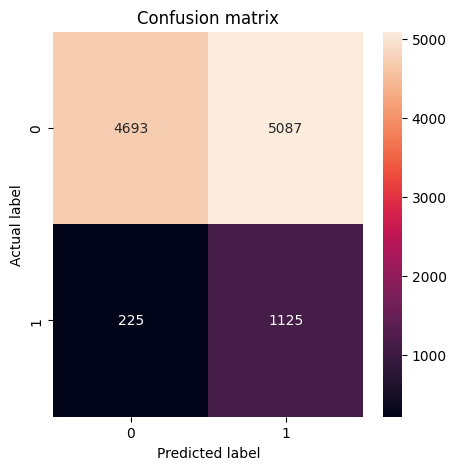

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = decision_tree.predict_proba(test[feature_for_dt])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)
# y_pred = decision_tree.predict(valid[feature_for_dt])

plot_cm(y_test, y_pred)

# Hyperparameter tuning for random forest

## Summary of encodings for random forest

- **job**: One-Hot encoding
- **martial**: One-Hot encoding
- **education**: Leave-one-out encoder	
- **default**: One-Hot encoding	
- **housing**: Leave-one-out encoder	
- **loan**: One-Hot encoding
- **contact**: One-Hot encoding
- **month**: One-Hot encoding
- **day_of_week**: Leave-one-out encoder	
- **poutcome**: One-Hot encoding

In [27]:
best_encodings_for_rf = {'OneHot': ['job', 'marital', 'default', 'loan', 'contact', 'month', 'poutcome'], 'LeaveOneOut': ['education', 'housing', 'day_of_week']}

best_features_for_rf = get_feature_encodings(best_encodings_for_rf)

## Random Forest without tuning

In [28]:
features = ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
feature_for_rf = best_features_for_rf + features

random_forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
results, fitted_model = get_model_performance(random_forest, feature_for_rf, "Random Forest")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))


,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Random Forest,0.38801,0.40746,0.74815,0.76,0.56943,0.19591,0.31152


## Random Forest with tuning

In [ ]:
len(feature_for_rf)

48

In [ ]:
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 40)
    max_features = trial.suggest_int('max_features', 1, 39)
    max_depth = trial.suggest_int('max_depth', 1, 40)
    
    
    model = RandomForestClassifier(n_estimators = 100,  
                                  criterion = criterion,  
                                  max_features = max_features, 
                                  min_samples_leaf= min_samples_leaf,
                                  max_depth=max_depth,
                                  random_state = 42)
  
    scores = cross_val_score(model, train[feature_for_rf], y_train, cv = 5, scoring = 'f1')
    loss = np.mean(scores)
    
    return loss

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials = 1000, timeout = 2000) 

[I 2023-05-23 11:46:36,929] A new study created in memory with name: no-name-47a2001f-1f1b-4044-bc70-1e61cfc65c25
[I 2023-05-23 11:46:47,584] Trial 0 finished with value: 0.3452565719485903 and parameters: {'criterion': 'gini', 'min_samples_leaf': 30, 'max_features': 24, 'max_depth': 7}. Best is trial 0 with value: 0.3452565719485903.
[I 2023-05-23 11:47:02,764] Trial 1 finished with value: 0.34637663252700945 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 35, 'max_features': 24, 'max_depth': 29}. Best is trial 1 with value: 0.34637663252700945.
[I 2023-05-23 11:47:09,532] Trial 2 finished with value: 0.32072257975482144 and parameters: {'criterion': 'gini', 'min_samples_leaf': 34, 'max_features': 9, 'max_depth': 8}. Best is trial 1 with value: 0.34637663252700945.
[I 2023-05-23 11:47:21,659] Trial 3 finished with value: 0.3447117193622332 and parameters: {'criterion': 'gini', 'min_samples_leaf': 21, 'max_features': 17, 'max_depth': 12}. Best is trial 1 with value: 0.3463

KeyboardInterrupt: ignored

In [29]:
# params = study.best_params
params = {'criterion': 'entropy',
 'min_samples_leaf': 20,
 'max_features': 21,
 'max_depth': 7}

In [30]:
feature_for_rf

['job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'default_no',
 'default_unknown',
 'default_yes',
 'loan_no',
 'loan_unknown',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'poutcome_failure',
 'poutcome_nonexistent',
 'poutcome_success',
 'educationLeaveOneOut',
 'housingLeaveOneOut',
 'day_of_weekLeaveOneOut',
 'age',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor_3m',
 'nr_employed']

In [31]:
random_forest = RandomForestClassifier(**params, n_estimators = 1000,
                                        random_state = 42)
results, fitted_model = get_model_performance(random_forest, feature_for_rf, "Random Forest")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Random Forest,0.28742,0.57862,0.80043,0.90741,0.35429,0.16247,0.27559


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


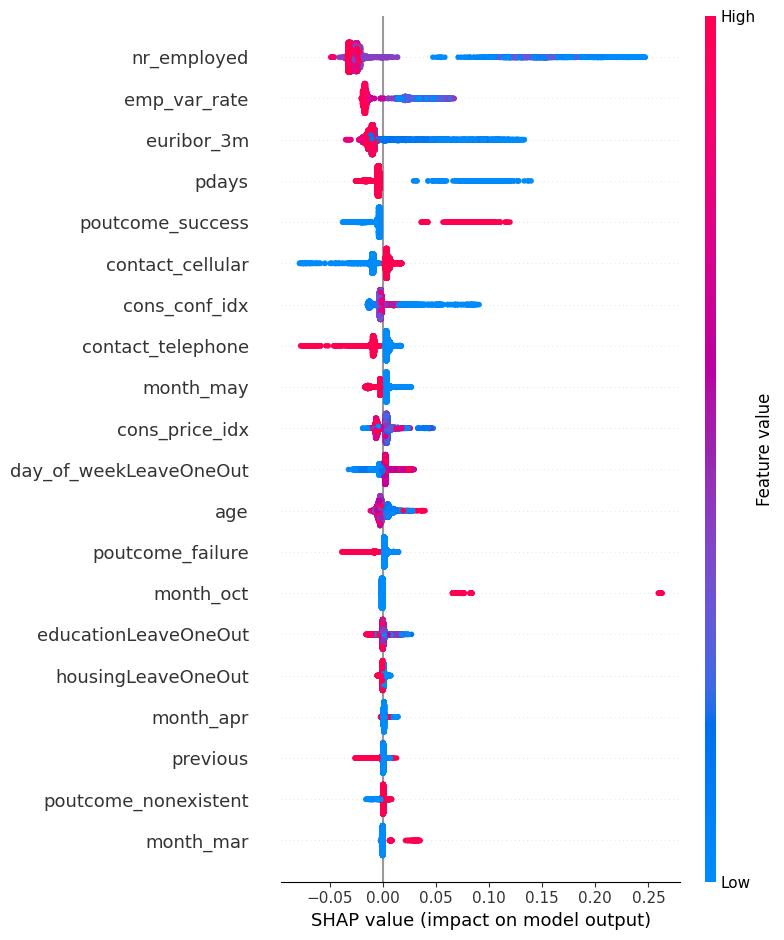

In [32]:
shap.initjs()

explainer = shap.Explainer(fitted_model)
shap_values = explainer.shap_values(test[feature_for_rf])
shap.summary_plot(shap_values[1], test[feature_for_rf])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


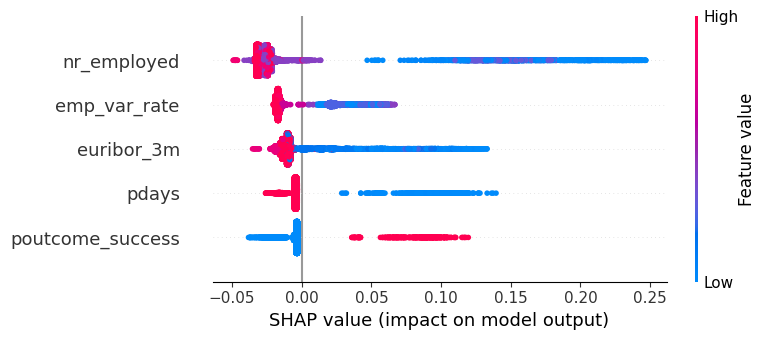

In [34]:
shap.summary_plot(shap_values[1], test[feature_for_rf], max_display=5)

## Confusion matrix for random forest

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = random_forest.predict_proba(valid[feature_for_rf])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)

plot_cm(y_valid, y_pred)

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = random_forest.predict_proba(test[feature_for_rf])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)

plot_cm(y_test, y_pred)

# Bagging without tuning

## Summary of encodings for bagging

- **job**: One-Hot/GLMM encoder
- **martial**: One-Hot/Target encoder
- **education**: Target encoder
- **default**: One-Hot encoder
- **housing**: GLMM
- **loan**: One-Hot/GLMM
- **contact**: One-Hot/target encoding
- **month**: One-Hot/Target
- **day_of_week**: GLMM
- **poutcome**: One-Hot

      # for i in range(len(rows)):
      #   if i == 5 and x != 'education':
      #     continue
      #   feature = []
      #   if i==0:
      #       features = variables + globals()['%s_OneHot' % x]
      #   elif i==1: 
      #       features = variables + [x+'TE'] 
      #   elif i==2:
      #       features = variables + [x+'LeaveOneOut']
      #   elif i==3: 
      #       features = variables + [x+'GLMM']
      #   elif i==4: 
      #       features = variables + [x+'CatBoost']  
      #   if x == 'education':
      #     if i==5:
      #       features = variables + ['educationOrdinal']

In [ ]:
best_encodings_for_bag = {'OneHot': ['marital', 'default', 'loan', 'contact', 'poutcome'], 'TE': ['education', 'month'], 'GLMM': ['job', 'housing', 'day_of_week'], 'LeaveOneOut': ['education', 'housing']}

best_features_for_bag = get_feature_encodings(best_encodings_for_bag)
print(best_features_for_bag)
features = ['age', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']
feature_for_bag = best_features_for_bag + features

In [ ]:
base_bag = BaggingClassifier(tree.DecisionTreeClassifier(criterion='entropy'), n_estimators=100, random_state=42)

results, fitted_model = get_model_performance(base_bag, feature_for_bag, "Bagging with trees")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = base_bag.predict_proba(valid[feature_for_bag])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)

plot_cm(y_valid, y_pred)

In [ ]:
len(feature_for_bag)

## Tuning bagging with optuna

In [ ]:
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 2, 200)
    max_samples = trial.suggest_int('max_samples', 1, 2000)
    max_features = trial.suggest_int('max_features', 1, 30)
    
    
    model = BaggingClassifier(n_estimators = n_estimators,  
                                  max_samples= max_samples,
                                  max_features=max_features,
                                  random_state = 42)
  
    scores = cross_val_score(model, train[feature_for_bag], y_train, cv = 5, scoring = 'f1')
    loss = np.mean(scores)
    
    return loss

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials = 1000, timeout = 2000) 

In [ ]:
params = study.best_params

In [ ]:
params = {'n_estimators': 194, 'max_samples': 1660, 'max_features': 5}

In [ ]:
tuned_bag = BaggingClassifier(**params, random_state=42)

results, fitted_model = get_model_performance(tuned_bag, feature_for_bag, "Bagging")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = tuned_bag.predict_proba(valid[feature_for_bag])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)

plot_cm(y_valid, y_pred)

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = tuned_bag.predict_proba(test[feature_for_bag])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)

plot_cm(y_test, y_pred)